# Fake Political News Detection using NLP
## IE7500 Applied NLP for Engineers - Project
**Author:** Cosmos Ameyaw Kwakye

This notebook implements a complete pipeline for detecting fake political news using the LIAR dataset.

## 1. Setup and Library Imports

In [11]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Core libraries imported successfully")

✓ Core libraries imported successfully


In [12]:
# NLP and Text Processing
import re
import string
from collections import Counter

# NLTK for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

print("✓ NLP libraries imported and NLTK data downloaded")

✓ NLP libraries imported and NLTK data downloaded


In [13]:
# Machine Learning - Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.preprocessing import LabelEncoder

print("✓ Scikit-learn libraries imported")

✓ Scikit-learn libraries imported


In [14]:
# Deep Learning Libraries

# For Word Embeddings and MLP
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ Keras version: {keras.__version__}")

# Check for GPU
if tf.config.list_physical_devices('GPU'):
    print("✓ GPU available!")
else:
    print("✓ Running on CPU")

# OR PyTorch (choose one)
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader

# For BERT (Phase 4)
# from transformers import (
#     BertTokenizer, BertForSequenceClassification,
#     Trainer, TrainingArguments
# )

print("✓ Deep learning imports ready")

✓ TensorFlow version: 2.19.0
✓ Keras version: 3.10.0
✓ GPU available!
✓ Deep learning imports ready


## 2. Data Loading

The LIAR dataset has the following structure:
- Column 1: ID
- Column 2: Label (6 classes)
- Column 3: Statement
- Column 4: Subject
- Column 5: Speaker
- Column 6: Job Title
- Column 7: State Info
- Column 8: Party Affiliation
- Column 9-13: Credit History Counts
- Column 14: Context

In [15]:
# Define column names for the LIAR dataset
column_names = [
    'id', 'label', 'statement', 'subject', 'speaker', 'job_title',
    'state_info', 'party_affiliation', 'barely_true_counts',
    'false_counts', 'half_true_counts', 'mostly_true_counts',
    'pants_on_fire_counts', 'context'
]

# Manual Upload in Google Colab
print("Please upload your LIAR dataset files (train.tsv, valid.tsv, test.tsv)")
print("=" * 70)

from google.colab import files
import io

# Upload files
print("\n Click 'Choose Files' to upload train.tsv, valid.tsv, and test.tsv")
uploaded = files.upload()

# Check if all files were uploaded
required_files = ['train.tsv', 'valid.tsv', 'test.tsv']
uploaded_files = list(uploaded.keys())

if all(file in uploaded_files for file in required_files):
    print("\n✓ All files uploaded successfully!")

    # Load the datasets
    train_df = pd.read_csv(io.BytesIO(uploaded['train.tsv']),
                           sep='\t', names=column_names, header=None)
    val_df = pd.read_csv(io.BytesIO(uploaded['valid.tsv']),
                         sep='\t', names=column_names, header=None)
    test_df = pd.read_csv(io.BytesIO(uploaded['test.tsv']),
                          sep='\t', names=column_names, header=None)

    print(f"\n✓ Data loaded successfully!")
    print(f"  Training set: {len(train_df)} samples")
    print(f"  Validation set: {len(val_df)} samples")
    print(f"  Test set: {len(test_df)} samples")
    print(f"  Total: {len(train_df) + len(val_df) + len(test_df)} samples")

else:
    print("\n⚠️ Not all required files were uploaded!")
    print(f"Required: {required_files}")
    print(f"Uploaded: {uploaded_files}")
    print("\nPlease run this cell again and upload all three files.")

Please upload your LIAR dataset files (train.tsv, valid.tsv, test.tsv)

 Click 'Choose Files' to upload train.tsv, valid.tsv, and test.tsv


Saving test.tsv to test.tsv
Saving train.tsv to train.tsv
Saving valid.tsv to valid.tsv

✓ All files uploaded successfully!

✓ Data loaded successfully!
  Training set: 10240 samples
  Validation set: 1284 samples
  Test set: 1267 samples
  Total: 12791 samples


## 3. Initial Data Exploration

In [16]:
# Display first few rows
print("First 5 rows of training data:")
print("=" * 100)
train_df.head()

First 5 rows of training data:


,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started when natural gas took off that started to begin i...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt ...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to mandate free sex change surgeries.,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of my term.,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [17]:
# Dataset info
print("Dataset Information:")
print("=" * 50)
train_df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10240 non-null  object 
 1   label                 10240 non-null  object 
 2   statement             10240 non-null  object 
 3   subject               10238 non-null  object 
 4   speaker               10238 non-null  object 
 5   job_title             7342 non-null   object 
 6   state_info            8030 non-null   object 
 7   party_affiliation     10238 non-null  object 
 8   barely_true_counts    10238 non-null  float64
 9   false_counts          10238 non-null  float64
 10  half_true_counts      10238 non-null  float64
 11  mostly_true_counts    10238 non-null  float64
 12  pants_on_fire_counts  10238 non-null  float64
 13  context               10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


In [18]:
# Check for missing values
print("Missing Values:")
print("=" * 50)
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

Missing Values:
                      Missing Count  Percentage
job_title                      2898   28.300781
state_info                     2210   21.582031
context                         102    0.996094
speaker                           2    0.019531
subject                           2    0.019531
barely_true_counts                2    0.019531
party_affiliation                 2    0.019531
false_counts                      2    0.019531
half_true_counts                  2    0.019531
mostly_true_counts                2    0.019531
pants_on_fire_counts              2    0.019531


In [19]:
# ============================================
# 3. CHECK FOR MISSING VALUES
# ============================================

print("Missing Values:")
print("=" * 50)
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

# ============================================
# 4. HANDLE MISSING VALUES (SIMPLE APPROACH)
# ============================================

print("\n" + "="*70)
print("MISSING VALUE HANDLING")
print("="*70)

# Check only the columns we need for classification
print("\nFor text classification, we need:")
print("  1. 'statement' column (the text to classify)")
print("  2. 'label' column (the target variable)")
print("\nChecking these columns:")

missing_statement = train_df['statement'].isnull().sum()
missing_label = train_df['label'].isnull().sum()

print(f"  Missing statements: {missing_statement}")
print(f"  Missing labels:     {missing_label}")

if missing_statement == 0 and missing_label == 0:
    print("\n✓ RESULT: No missing values in required columns!")
    print("✓ Dataset is ready for text classification.")
    print("\nNote: Missing values exist in metadata columns (job_title, state_info),")
    print("      but these are not used in our TF-IDF text classification approach.")
else:
    print(f"\n⚠️ Found {missing_statement + missing_label} rows with missing critical data")
    print("Removing these rows...")

    train_df = train_df.dropna(subset=['statement', 'label']).reset_index(drop=True)
    val_df = val_df.dropna(subset=['statement', 'label']).reset_index(drop=True)
    test_df = test_df.dropna(subset=['statement', 'label']).reset_index(drop=True)

    print("✓ Rows removed")

print("\n" + "="*70)
print(f"Final dataset sizes:")
print(f"  Training:   {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")
print(f"  Test:       {len(test_df)} samples")
print("="*70 + "\n")

Missing Values:
                      Missing Count  Percentage
job_title                      2898   28.300781
state_info                     2210   21.582031
context                         102    0.996094
speaker                           2    0.019531
subject                           2    0.019531
barely_true_counts                2    0.019531
party_affiliation                 2    0.019531
false_counts                      2    0.019531
half_true_counts                  2    0.019531
mostly_true_counts                2    0.019531
pants_on_fire_counts              2    0.019531

MISSING VALUE HANDLING

For text classification, we need:
  1. 'statement' column (the text to classify)
  2. 'label' column (the target variable)

Checking these columns:
  Missing statements: 0
  Missing labels:     0

✓ RESULT: No missing values in required columns!
✓ Dataset is ready for text classification.

Note: Missing values exist in metadata columns (job_title, state_info),
      but these are 

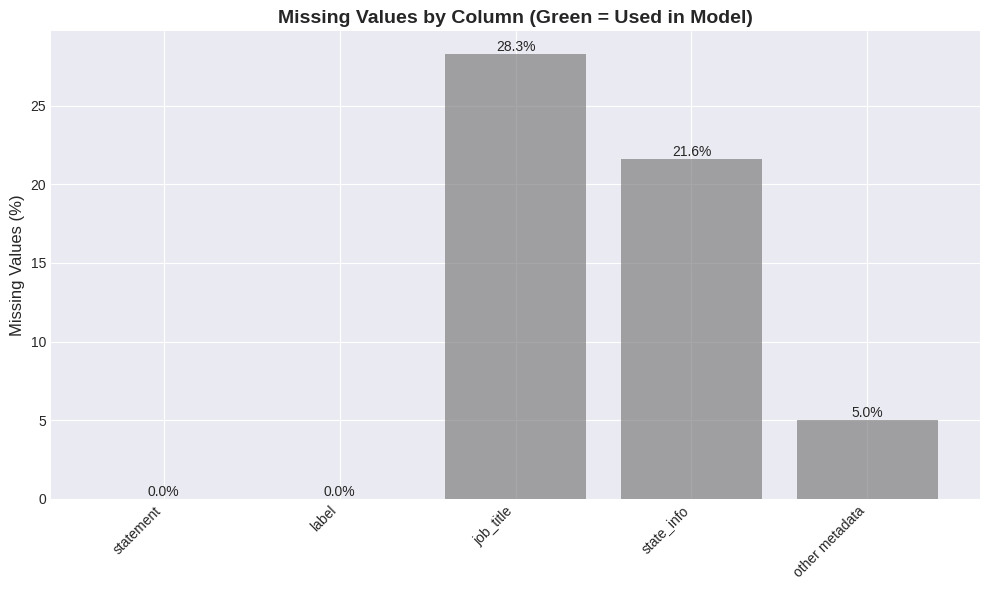

✓ We only use columns with 0% missing values (statement and label)


In [20]:
# Simple visualization of what we're using
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

columns = ['statement', 'label', 'job_title', 'state_info', 'other metadata']
missing_pct = [0, 0, 28.3, 21.6, 5.0]  # Approximate percentages
used_for_model = [True, True, False, False, False]

colors = ['green' if used else 'gray' for used in used_for_model]

bars = ax.bar(columns, missing_pct, color=colors, alpha=0.7)
ax.set_ylabel('Missing Values (%)', fontsize=12)
ax.set_title('Missing Values by Column (Green = Used in Model)', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels
for bar, pct in zip(bars, missing_pct):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("✓ We only use columns with 0% missing values (statement and label)")

In [21]:
# Label distribution
print("Label Distribution:")
print("=" * 50)
label_counts = train_df['label'].value_counts()
print(label_counts)
print(f"\nPercentages:")
print((label_counts / len(train_df) * 100).round(2))

Label Distribution:
label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64

Percentages:
label
half-true      20.64
false          19.48
mostly-true    19.16
true           16.37
barely-true    16.15
pants-fire      8.19
Name: count, dtype: float64


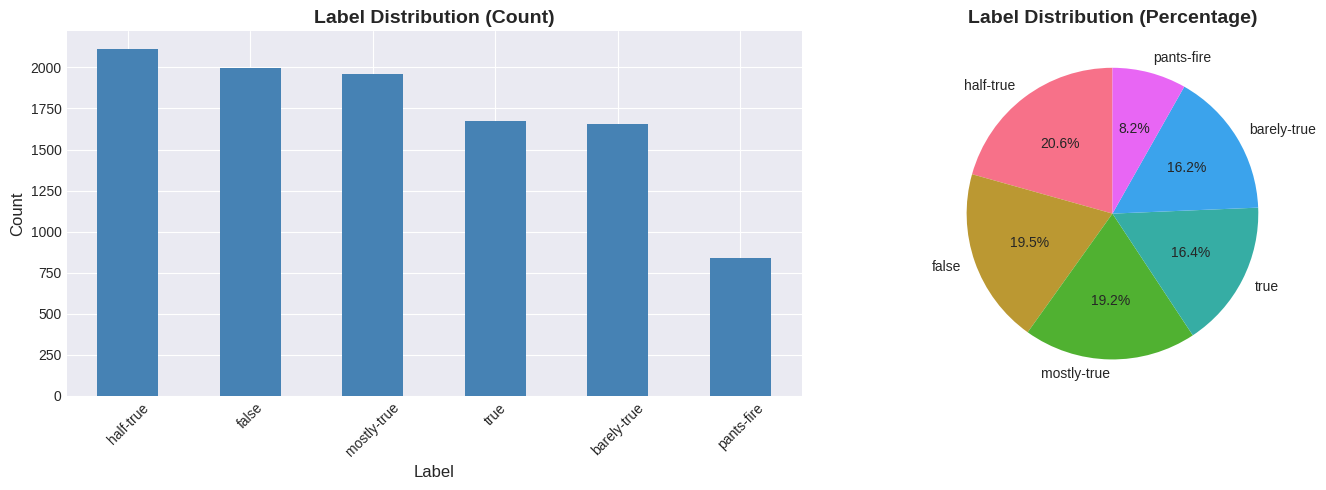

In [22]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
label_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Label Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Label Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [23]:
# Statement length analysis
train_df['statement_length'] = train_df['statement'].astype(str).apply(len)
train_df['word_count'] = train_df['statement'].astype(str).apply(lambda x: len(x.split()))

print("Statement Length Statistics:")
print("=" * 50)
print(train_df[['statement_length', 'word_count']].describe())

Statement Length Statistics:
       statement_length    word_count
count      10240.000000  10240.000000
mean         106.918750     18.010059
std           59.917722      9.658572
min           11.000000      2.000000
25%           73.000000     12.000000
50%           99.000000     17.000000
75%          132.250000     22.000000
max         3192.000000    467.000000


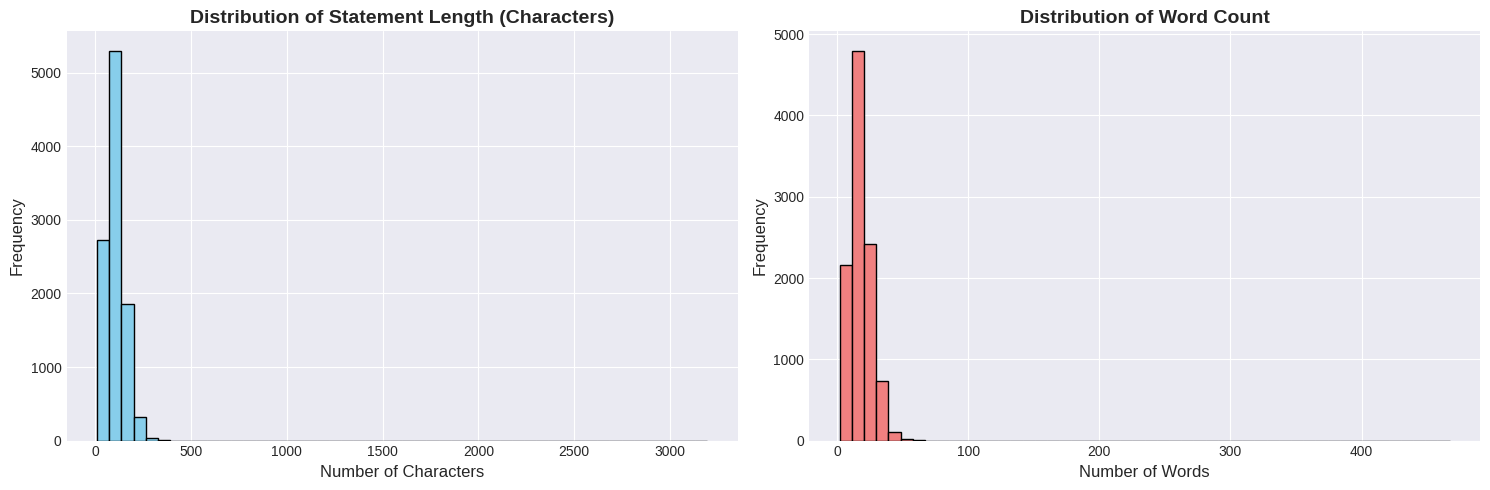

In [24]:
# Visualize statement lengths
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(train_df['statement_length'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Statement Length (Characters)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Characters', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

axes[1].hist(train_df['word_count'], bins=50, color='lightcoral', edgecolor='black')
axes[1].set_title('Distribution of Word Count', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Words', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

In [25]:
# Top speakers and subjects
print("\nTop 10 Speakers:")
print("=" * 50)
print(train_df['speaker'].value_counts().head(10))

print("\nTop 10 Subjects:")
print("=" * 50)
print(train_df['subject'].value_counts().head(10))


Top 10 Speakers:
speaker
barack-obama       488
donald-trump       273
hillary-clinton    239
mitt-romney        176
scott-walker       149
john-mccain        148
rick-perry         142
chain-email        142
marco-rubio        117
rick-scott         115
Name: count, dtype: int64

Top 10 Subjects:
subject
health-care             381
taxes                   308
immigration             253
elections               252
education               237
candidates-biography    190
economy                 137
guns                    130
economy,jobs            125
federal-budget          121
Name: count, dtype: int64


## 4. Data Preprocessing

### 4.1 Create Binary Labels

In [26]:
# Create binary labels: Fake (0) vs Real (1)
# Fake: pants-fire, false, barely-true
# Real: half-true, mostly-true, true

def create_binary_label(label):
    """
    Convert 6-class labels to binary classification
    """
    fake_labels = ['pants-fire', 'false', 'barely-true']
    real_labels = ['half-true', 'mostly-true', 'true']

    if label in fake_labels:
        return 0  # Fake
    elif label in real_labels:
        return 1  # Real
    else:
        return None  # Unknown

# Apply to all datasets
train_df['binary_label'] = train_df['label'].apply(create_binary_label)
val_df['binary_label'] = val_df['label'].apply(create_binary_label)
test_df['binary_label'] = test_df['label'].apply(create_binary_label)

print("Binary Label Distribution (Training Set):")
print("=" * 50)
print(train_df['binary_label'].value_counts())
print(f"\n0 = Fake, 1 = Real")
print(f"Fake: {(train_df['binary_label'] == 0).sum() / len(train_df) * 100:.2f}%")
print(f"Real: {(train_df['binary_label'] == 1).sum() / len(train_df) * 100:.2f}%")

Binary Label Distribution (Training Set):
binary_label
1    5752
0    4488
Name: count, dtype: int64

0 = Fake, 1 = Real
Fake: 43.83%
Real: 56.17%


### 4.2 Text Preprocessing Functions

In [27]:
# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Basic text cleaning: lowercase, remove special characters
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove mentions and hashtags (if any)
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

def tokenize_text(text):
    """
    Tokenize text into words
    """
    return word_tokenize(text)

def remove_stopwords(tokens):
    """
    Remove stopwords from token list
    """
    return [word for word in tokens if word not in stop_words and len(word) > 2]

def lemmatize_tokens(tokens):
    """
    Lemmatize tokens
    """
    return [lemmatizer.lemmatize(word) for word in tokens]

def preprocess_text(text):
    """
    Complete preprocessing pipeline
    """
    # Clean text
    text = clean_text(text)

    # Tokenize
    tokens = tokenize_text(text)

    # Remove stopwords
    tokens = remove_stopwords(tokens)

    # Lemmatize
    tokens = lemmatize_tokens(tokens)

    # Join back to string
    return ' '.join(tokens)

print("✓ Preprocessing functions defined")

✓ Preprocessing functions defined


In [28]:
import nltk
nltk.download('punkt_tab')

# Test preprocessing on sample statements
print("Preprocessing Examples:")
print("=" * 100)

for i in range(min(3, len(train_df))):
    original = train_df['statement'].iloc[i]
    processed = preprocess_text(original)

    print(f"\nOriginal {i+1}:")
    print(f"  {original}")
    print(f"\nProcessed {i+1}:")
    print(f"  {processed}")
    print("-" * 100)

Preprocessing Examples:


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Original 1:
  Says the Annies List political group supports third-trimester abortions on demand.

Processed 1:
  say annies list political group support thirdtrimester abortion demand
----------------------------------------------------------------------------------------------------

Original 2:
  When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.

Processed 2:
  decline coal start started natural gas took started begin president george bush administration
----------------------------------------------------------------------------------------------------

Original 3:
  Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."

Processed 3:
  hillary clinton agrees john mccain voting give george bush benefit doubt iran
----------------------------------------------------------------------------------------------------


In [29]:
# Apply preprocessing to all datasets
print("Applying preprocessing to datasets...")
print("This may take a few minutes...\n")

train_df['processed_statement'] = train_df['statement'].apply(preprocess_text)
val_df['processed_statement'] = val_df['statement'].apply(preprocess_text)
test_df['processed_statement'] = test_df['statement'].apply(preprocess_text)

print("✓ Preprocessing complete!")
print(f"  Training set: {len(train_df)} samples processed")
print(f"  Validation set: {len(val_df)} samples processed")
print(f"  Test set: {len(test_df)} samples processed")

Applying preprocessing to datasets...
This may take a few minutes...

✓ Preprocessing complete!
  Training set: 10240 samples processed
  Validation set: 1284 samples processed
  Test set: 1267 samples processed


## 5. Prepare Data for Modeling

In [30]:
# Extract features and labels
X_train = train_df['processed_statement'].values
y_train = train_df['binary_label'].values

X_val = val_df['processed_statement'].values
y_val = val_df['binary_label'].values

X_test = test_df['processed_statement'].values
y_test = test_df['binary_label'].values

print("Data prepared for modeling:")
print("=" * 50)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(f"  Fake (0): {(y_train == 0).sum()}")
print(f"  Real (1): {(y_train == 1).sum()}")

Data prepared for modeling:
Training set: 10240 samples
Validation set: 1284 samples
Test set: 1267 samples

Class distribution in training set:
  Fake (0): 4488
  Real (1): 5752


## 6. Save Preprocessed Data

In [31]:
# Save preprocessed dataframes for future use
train_df.to_csv('train_preprocessed.csv', index=False)
val_df.to_csv('val_preprocessed.csv', index=False)
test_df.to_csv('test_preprocessed.csv', index=False)

print("✓ Preprocessed data saved!")
print("  Files: train_preprocessed.csv, val_preprocessed.csv, test_preprocessed.csv")

✓ Preprocessed data saved!
  Files: train_preprocessed.csv, val_preprocessed.csv, test_preprocessed.csv


## Next Steps

Now that we have preprocessed data, we can proceed to:

1. **Phase 2: Baseline Models**
   - TF-IDF vectorization
   - Logistic Regression
   - Naive Bayes

2. **Phase 3: Word Embeddings + MLP**
   - Load pre-trained embeddings (GloVe/Word2Vec)
   - Build neural network models

3. **Phase 4: BERT Fine-tuning**
   - Prepare data for BERT
   - Fine-tune pre-trained BERT model

Continue to the next notebook for baseline modeling!

In [32]:
# ============================================
# PHASE 2: BASELINE MODELS
# ============================================

print("\n" + "="*70)
print("PHASE 2: BUILDING BASELINE MODELS")
print("="*70)
print("\nWe will now build baseline models using:")
print("  1. TF-IDF vectorization")
print("  2. Logistic Regression")
print("  3. Naive Bayes")
print("="*70 + "\n")


PHASE 2: BUILDING BASELINE MODELS

We will now build baseline models using:
  1. TF-IDF vectorization
  2. Logistic Regression
  3. Naive Bayes



## 2. TF-IDF Vectorization

In [33]:
# Create TF-IDF vectorizer
# We'll experiment with different parameters

print("Creating TF-IDF vectorizer...\n")

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,        # Limit to top 5000 features
    ngram_range=(1, 2),       # Use unigrams and bigrams
    min_df=2,                 # Ignore terms that appear in less than 2 documents
    max_df=0.8,               # Ignore terms that appear in more than 80% of documents
    sublinear_tf=True,        # Apply sublinear scaling to term frequency
    use_idf=True
)

# Fit on training data and transform all sets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"✓ TF-IDF vectorization complete")
print(f"  Feature matrix shape (train): {X_train_tfidf.shape}")
print(f"  Feature matrix shape (val): {X_val_tfidf.shape}")
print(f"  Feature matrix shape (test): {X_test_tfidf.shape}")
print(f"  Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

Creating TF-IDF vectorizer...

✓ TF-IDF vectorization complete
  Feature matrix shape (train): (10240, 5000)
  Feature matrix shape (val): (1284, 5000)
  Feature matrix shape (test): (1267, 5000)
  Vocabulary size: 5000


In [34]:
# Examine top TF-IDF features
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get average TF-IDF scores
tfidf_scores = X_train_tfidf.mean(axis=0).A1
top_indices = tfidf_scores.argsort()[-20:][::-1]

print("\nTop 20 TF-IDF Features:")
print("=" * 50)
for idx in top_indices:
    print(f"{feature_names[idx]:30} {tfidf_scores[idx]:.4f}")


Top 20 TF-IDF Features:
say                            0.0285
state                          0.0188
percent                        0.0174
year                           0.0165
tax                            0.0153
obama                          0.0126
president                      0.0109
job                            0.0108
people                         0.0106
million                        0.0102
health                         0.0101
would                          0.0090
care                           0.0090
one                            0.0090
country                        0.0087
american                       0.0085
bill                           0.0084
new                            0.0083
time                           0.0080
texas                          0.0080


## 3. Helper Functions for Evaluation

In [35]:
def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Model"):
    """
    Comprehensive model evaluation
    """
    print(f"\n{'='*60}")
    print(f"{model_name} Evaluation Results")
    print(f"{'='*60}\n")

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    if y_pred_proba is not None:
        auc = roc_auc_score(y_true, y_pred_proba)
        print(f"ROC-AUC:   {auc:.4f}")

    # Classification report
    print(f"\nDetailed Classification Report:")
    print("-" * 60)
    print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

    # Store results
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    if y_pred_proba is not None:
        results['auc'] = auc

    return results

def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fake', 'Real'],
                yticklabels=['Fake', 'Real'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(f"\nNormalized Confusion Matrix:")
    print("=" * 40)
    print(f"True Negatives:  {cm_normalized[0, 0]:.2%}")
    print(f"False Positives: {cm_normalized[0, 1]:.2%}")
    print(f"False Negatives: {cm_normalized[1, 0]:.2%}")
    print(f"True Positives:  {cm_normalized[1, 1]:.2%}")

def plot_roc_curve(y_true, y_pred_proba, model_name="Model"):
    """
    Plot ROC curve
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("✓ Evaluation functions defined")

✓ Evaluation functions defined


## 4. Baseline Model 1: Logistic Regression

In [36]:
print("Training Logistic Regression model...\n")

# Initialize model
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_SEED,
    C=1.0,                    # Regularization parameter
    class_weight='balanced',  # Handle class imbalance
    solver='lbfgs'
)

# Train model
lr_model.fit(X_train_tfidf, y_train)

print("✓ Training complete!")

# Make predictions
y_train_pred_lr = lr_model.predict(X_train_tfidf)
y_val_pred_lr = lr_model.predict(X_val_tfidf)
y_test_pred_lr = lr_model.predict(X_test_tfidf)

# Get probability predictions
y_train_proba_lr = lr_model.predict_proba(X_train_tfidf)[:, 1]
y_val_proba_lr = lr_model.predict_proba(X_val_tfidf)[:, 1]
y_test_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

Training Logistic Regression model...

✓ Training complete!


In [37]:
# Evaluate on training set
lr_train_results = evaluate_model(y_train, y_train_pred_lr, y_train_proba_lr,
                                   "Logistic Regression (Training Set)")


Logistic Regression (Training Set) Evaluation Results

Accuracy:  0.7608
Precision: 0.8050
Recall:    0.7578
F1-Score:  0.7807
ROC-AUC:   0.8368

Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

        Fake       0.71      0.76      0.74      4488
        Real       0.80      0.76      0.78      5752

    accuracy                           0.76     10240
   macro avg       0.76      0.76      0.76     10240
weighted avg       0.76      0.76      0.76     10240



In [38]:
# Evaluate on validation set
lr_val_results = evaluate_model(y_val, y_val_pred_lr, y_val_proba_lr,
                                 "Logistic Regression (Validation Set)")


Logistic Regression (Validation Set) Evaluation Results

Accuracy:  0.6137
Precision: 0.6299
Recall:    0.6243
F1-Score:  0.6271
ROC-AUC:   0.6639

Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

        Fake       0.60      0.60      0.60       616
        Real       0.63      0.62      0.63       668

    accuracy                           0.61      1284
   macro avg       0.61      0.61      0.61      1284
weighted avg       0.61      0.61      0.61      1284



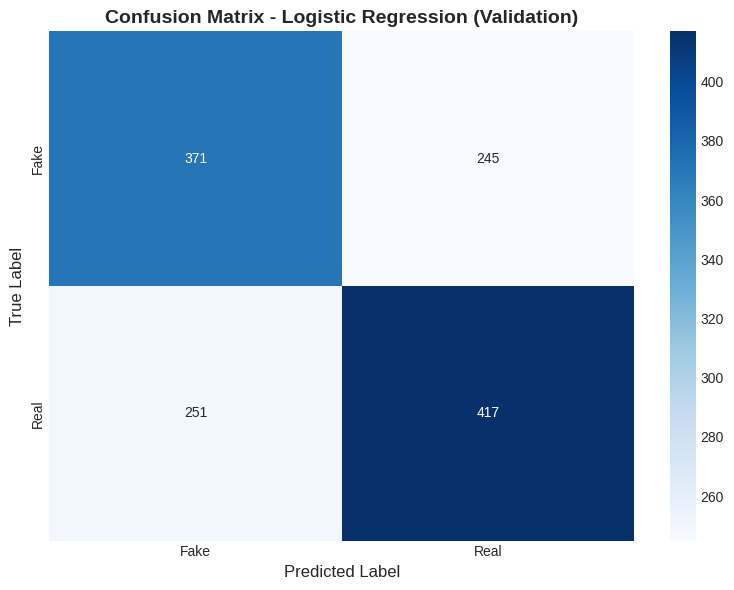


Normalized Confusion Matrix:
True Negatives:  60.23%
False Positives: 39.77%
False Negatives: 37.57%
True Positives:  62.43%


In [39]:
# Plot confusion matrix
plot_confusion_matrix(y_val, y_val_pred_lr, "Logistic Regression (Validation)")

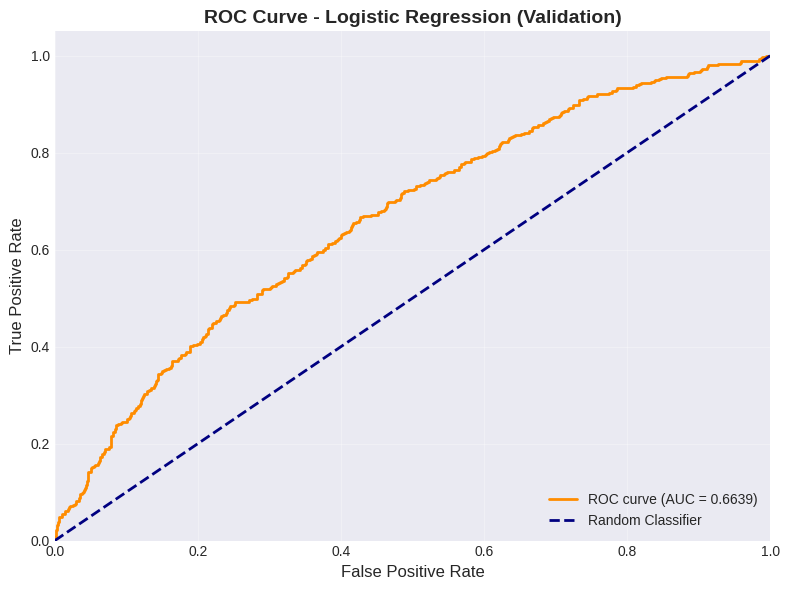

In [40]:
# Plot ROC curve
plot_roc_curve(y_val, y_val_proba_lr, "Logistic Regression (Validation)")

In [41]:
# Examine top predictive features
feature_importance = lr_model.coef_[0]
top_positive_idx = feature_importance.argsort()[-20:][::-1]
top_negative_idx = feature_importance.argsort()[:20]

print("\nTop 20 Features Predicting REAL News:")
print("=" * 60)
for idx in top_positive_idx:
    print(f"{feature_names[idx]:30} {feature_importance[idx]:8.4f}")

print("\nTop 20 Features Predicting FAKE News:")
print("=" * 60)
for idx in top_negative_idx:
    print(f"{feature_names[idx]:30} {feature_importance[idx]:8.4f}")


Top 20 Features Predicting REAL News:
percent                          2.1700
since                            2.0111
georgia                          1.9747
debt                             1.6525
still                            1.6362
average                          1.6011
day                              1.5989
decade                           1.5935
lower                            1.5427
worth                            1.5073
say scott                        1.4858
country                          1.4591
three                            1.4330
shutdown                         1.4311
firearm                          1.4273
accident                         1.3611
corporation                      1.3556
indiana                          1.3269
million                          1.2854
act                              1.2833

Top 20 Features Predicting FAKE News:
rep                             -1.9672
obamacare                       -1.6303
group                           -1.5998
ob

## 5. Baseline Model 2: Multinomial Naive Bayes

In [42]:
print("Training Multinomial Naive Bayes model...\n")

# Initialize model
nb_model = MultinomialNB(alpha=1.0)  # Laplace smoothing

# Train model
nb_model.fit(X_train_tfidf, y_train)

print("✓ Training complete!")

# Make predictions
y_train_pred_nb = nb_model.predict(X_train_tfidf)
y_val_pred_nb = nb_model.predict(X_val_tfidf)
y_test_pred_nb = nb_model.predict(X_test_tfidf)

# Get probability predictions
y_train_proba_nb = nb_model.predict_proba(X_train_tfidf)[:, 1]
y_val_proba_nb = nb_model.predict_proba(X_val_tfidf)[:, 1]
y_test_proba_nb = nb_model.predict_proba(X_test_tfidf)[:, 1]

Training Multinomial Naive Bayes model...

✓ Training complete!


In [43]:
# Evaluate on training set
nb_train_results = evaluate_model(y_train, y_train_pred_nb, y_train_proba_nb,
                                   "Naive Bayes (Training Set)")


Naive Bayes (Training Set) Evaluation Results

Accuracy:  0.7381
Precision: 0.7248
Recall:    0.8604
F1-Score:  0.7868
ROC-AUC:   0.8170

Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

        Fake       0.76      0.58      0.66      4488
        Real       0.72      0.86      0.79      5752

    accuracy                           0.74     10240
   macro avg       0.74      0.72      0.72     10240
weighted avg       0.74      0.74      0.73     10240



In [44]:
# Evaluate on validation set
nb_val_results = evaluate_model(y_val, y_val_pred_nb, y_val_proba_nb,
                                 "Naive Bayes (Validation Set)")


Naive Bayes (Validation Set) Evaluation Results

Accuracy:  0.6145
Precision: 0.6005
Recall:    0.7740
F1-Score:  0.6763
ROC-AUC:   0.6646

Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

        Fake       0.64      0.44      0.52       616
        Real       0.60      0.77      0.68       668

    accuracy                           0.61      1284
   macro avg       0.62      0.61      0.60      1284
weighted avg       0.62      0.61      0.60      1284



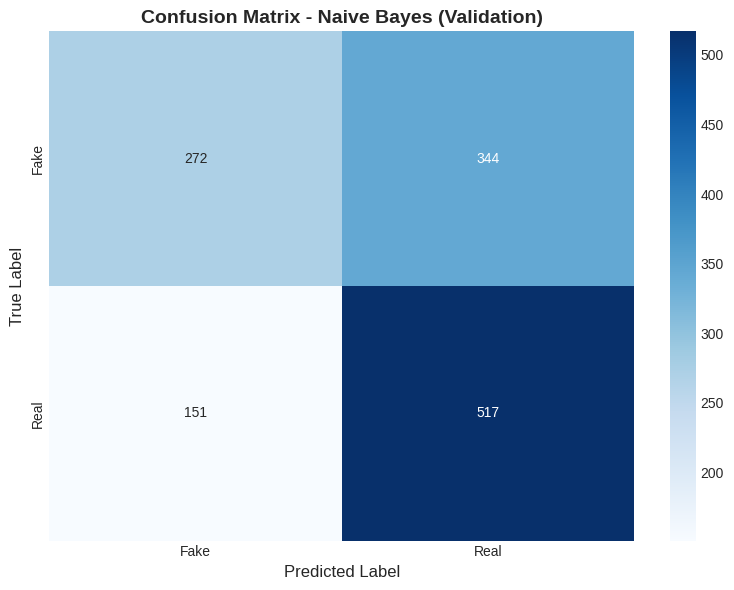


Normalized Confusion Matrix:
True Negatives:  44.16%
False Positives: 55.84%
False Negatives: 22.60%
True Positives:  77.40%


In [45]:
# Plot confusion matrix
plot_confusion_matrix(y_val, y_val_pred_nb, "Naive Bayes (Validation)")

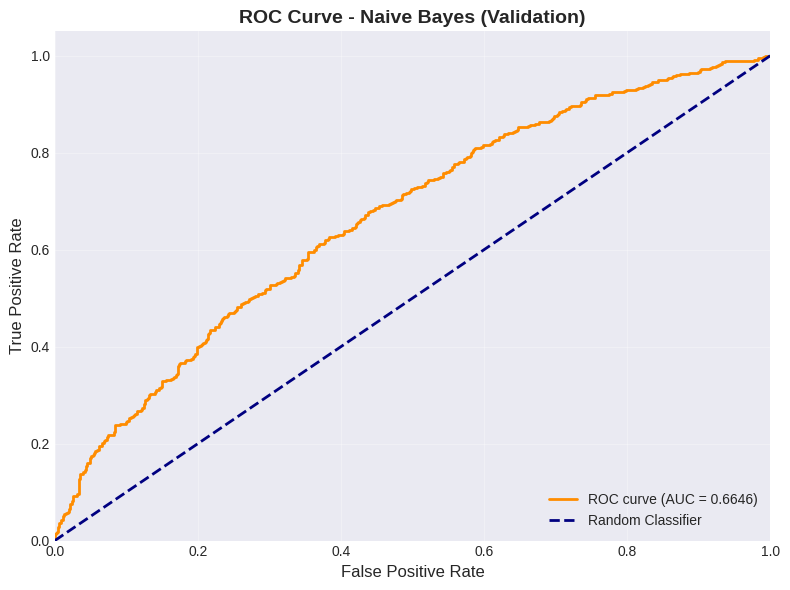

In [46]:
# Plot ROC curve
plot_roc_curve(y_val, y_val_proba_nb, "Naive Bayes (Validation)")

## 6. Hyperparameter Tuning

In [47]:
# Grid search for Logistic Regression
print("Performing Grid Search for Logistic Regression...\n")
print("This may take several minutes...\n")

param_grid_lr = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

grid_search_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, class_weight='balanced'),
    param_grid_lr,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_lr.fit(X_train_tfidf, y_train)

print(f"\n✓ Grid Search Complete!")
print(f"Best parameters: {grid_search_lr.best_params_}")
print(f"Best F1 score: {grid_search_lr.best_score_:.4f}")

Performing Grid Search for Logistic Regression...

This may take several minutes...

Fitting 3 folds for each of 6 candidates, totalling 18 fits

✓ Grid Search Complete!
Best parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1 score: 0.6319


In [48]:
# Evaluate tuned model
best_lr_model = grid_search_lr.best_estimator_
y_val_pred_lr_tuned = best_lr_model.predict(X_val_tfidf)
y_val_proba_lr_tuned = best_lr_model.predict_proba(X_val_tfidf)[:, 1]

lr_tuned_results = evaluate_model(y_val, y_val_pred_lr_tuned, y_val_proba_lr_tuned,
                                   "Tuned Logistic Regression (Validation)")


Tuned Logistic Regression (Validation) Evaluation Results

Accuracy:  0.6106
Precision: 0.6265
Recall:    0.6228
F1-Score:  0.6246
ROC-AUC:   0.6649

Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

        Fake       0.59      0.60      0.60       616
        Real       0.63      0.62      0.62       668

    accuracy                           0.61      1284
   macro avg       0.61      0.61      0.61      1284
weighted avg       0.61      0.61      0.61      1284



## 7. Compare Models

In [49]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'Tuned LR'],
    'Accuracy': [lr_val_results['accuracy'], nb_val_results['accuracy'], lr_tuned_results['accuracy']],
    'Precision': [lr_val_results['precision'], nb_val_results['precision'], lr_tuned_results['precision']],
    'Recall': [lr_val_results['recall'], nb_val_results['recall'], lr_tuned_results['recall']],
    'F1-Score': [lr_val_results['f1'], nb_val_results['f1'], lr_tuned_results['f1']],
    'ROC-AUC': [lr_val_results['auc'], nb_val_results['auc'], lr_tuned_results['auc']]
})

print("\nModel Comparison on Validation Set:")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Find best model
best_model_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\n🏆 Best Model: {best_model_name} (F1-Score: {comparison_df.loc[best_model_idx, 'F1-Score']:.4f})")


Model Comparison on Validation Set:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.613707   0.629909 0.624251  0.627068 0.663874
        Naive Bayes  0.614486   0.600465 0.773952  0.676259 0.664639
           Tuned LR  0.610592   0.626506 0.622754  0.624625 0.664928

🏆 Best Model: Naive Bayes (F1-Score: 0.6763)


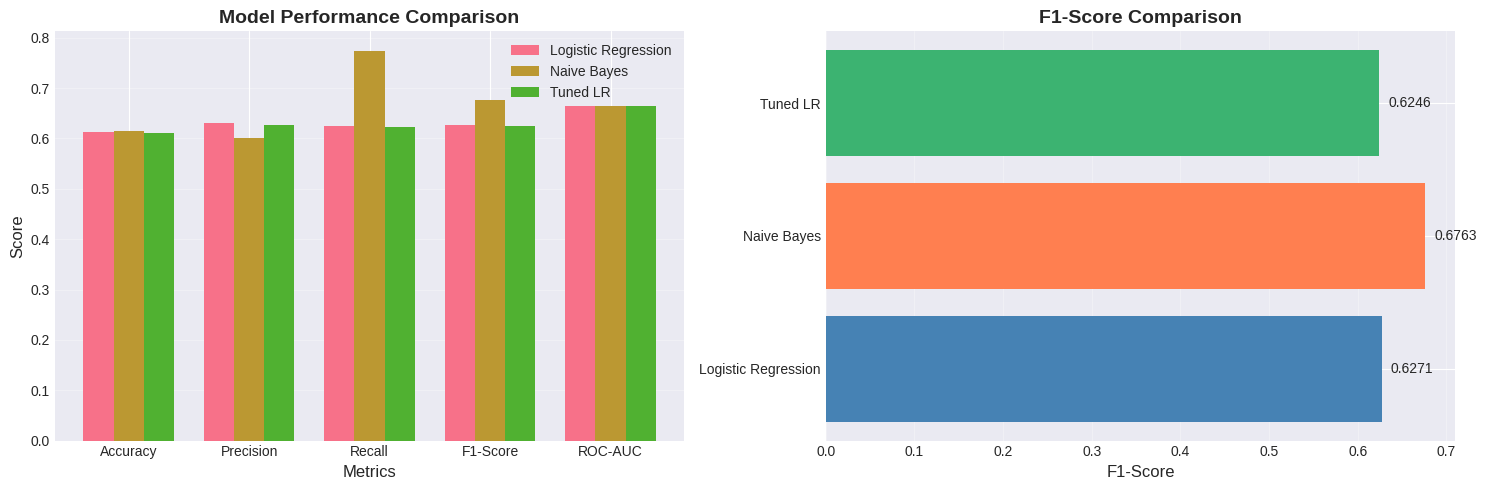

In [50]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot of metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.25

for i, model in enumerate(comparison_df['Model']):
    values = comparison_df.iloc[i, 1:].values
    axes[0].bar(x + i*width, values, width, label=model)

axes[0].set_xlabel('Metrics', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# F1-Score comparison
axes[1].barh(comparison_df['Model'], comparison_df['F1-Score'], color=['steelblue', 'coral', 'mediumseagreen'])
axes[1].set_xlabel('F1-Score', fontsize=12)
axes[1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(comparison_df['F1-Score']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()

## 8. Final Evaluation on Test Set

In [51]:
# ============================================
# 8. FINAL EVALUATION ON TEST SET
# ============================================

# Dynamically select the best model based on F1-score
print("Selecting best model based on validation F1-score...")
print("=" * 70)

# Compare F1-scores from all models
model_scores = {
    'Logistic Regression': lr_val_results['f1'],
    'Naive Bayes': nb_val_results['f1'],
    'Tuned Logistic Regression': lr_tuned_results['f1']
}

# Find the best model
best_model_name = max(model_scores, key=model_scores.get)
best_f1_score = model_scores[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Validation F1-Score: {best_f1_score:.4f}")
print("=" * 70)

# Select the corresponding model
if best_model_name == 'Logistic Regression':
    final_model = lr_model
    y_test_pred_final = y_test_pred_lr
    y_test_proba_final = y_test_proba_lr
elif best_model_name == 'Naive Bayes':
    final_model = nb_model
    y_test_pred_final = y_test_pred_nb
    y_test_proba_final = y_test_proba_nb
else:  # Tuned Logistic Regression
    final_model = best_lr_model
    y_test_pred_final = y_test_pred_lr_tuned
    y_test_proba_final = y_test_proba_lr_tuned

print(f"\n✓ Using {best_model_name} for final test evaluation\n")

# Evaluate on test set
test_results = evaluate_model(y_test, y_test_pred_final, y_test_proba_final,
                               f"{best_model_name} (TEST SET - FINAL)")

Selecting best model based on validation F1-score...

🏆 Best Model: Naive Bayes
   Validation F1-Score: 0.6763

✓ Using Naive Bayes for final test evaluation


Naive Bayes (TEST SET - FINAL) Evaluation Results

Accuracy:  0.6085
Precision: 0.6233
Recall:    0.7717
F1-Score:  0.6896
ROC-AUC:   0.6491

Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

        Fake       0.57      0.40      0.47       553
        Real       0.62      0.77      0.69       714

    accuracy                           0.61      1267
   macro avg       0.60      0.58      0.58      1267
weighted avg       0.60      0.61      0.59      1267



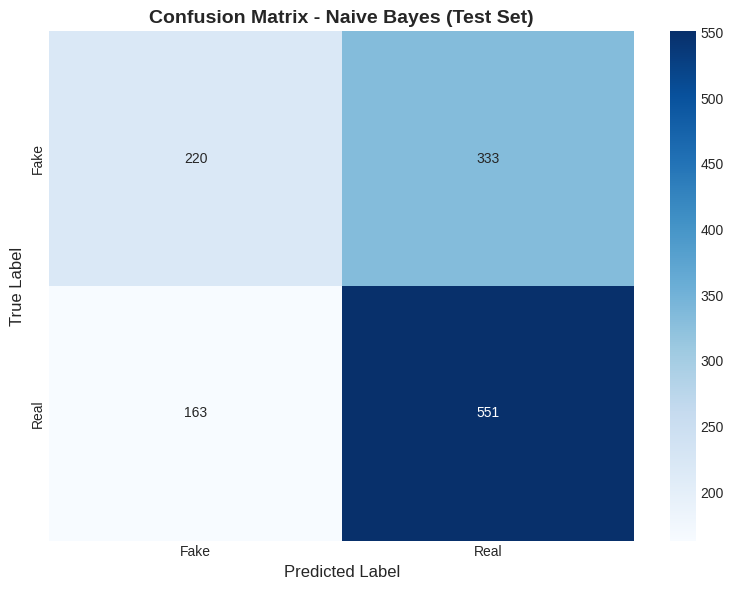


Normalized Confusion Matrix:
True Negatives:  39.78%
False Positives: 60.22%
False Negatives: 22.83%
True Positives:  77.17%


In [52]:
# Plot final confusion matrix
plot_confusion_matrix(y_test, y_test_pred_final, f"{best_model_name} (Test Set)")

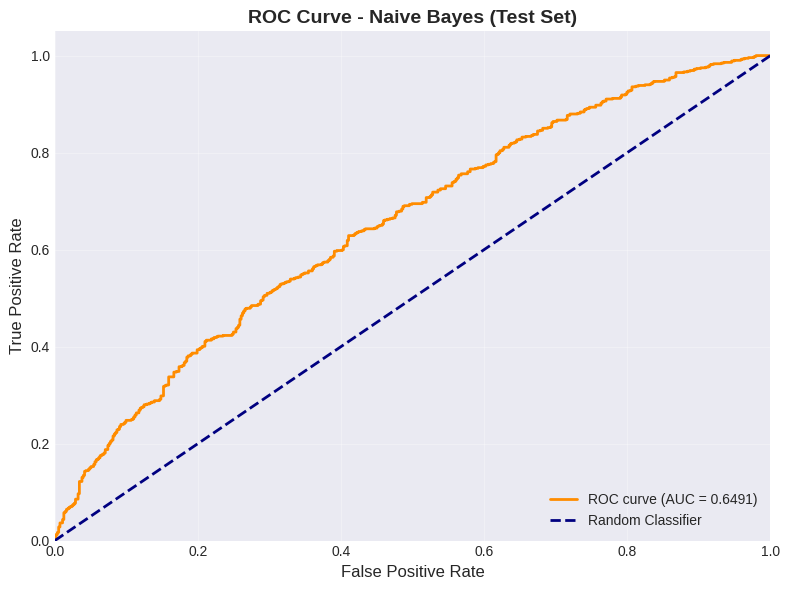

In [53]:
# Plot final ROC curve
plot_roc_curve(y_test, y_test_proba_final, f"{best_model_name} (Test Set)")

## 9. Error Analysis

In [54]:
# Analyze misclassifications
test_df_copy = test_df.copy()
test_df_copy['predicted'] = y_test_pred_final
test_df_copy['correct'] = test_df_copy['binary_label'] == test_df_copy['predicted']

# False Positives (predicted Real but actually Fake)
false_positives = test_df_copy[(test_df_copy['binary_label'] == 0) & (test_df_copy['predicted'] == 1)]

# False Negatives (predicted Fake but actually Real)
false_negatives = test_df_copy[(test_df_copy['binary_label'] == 1) & (test_df_copy['predicted'] == 0)]

print(f"\nError Analysis:")
print("=" * 60)
print(f"Total misclassifications: {(~test_df_copy['correct']).sum()}")
print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")


Error Analysis:
Total misclassifications: 496
False Positives: 333
False Negatives: 163


In [55]:
# Show examples of false positives
print("\nExamples of False Positives (Fake predicted as Real):")
print("=" * 80)
for i, row in false_positives.head(3).iterrows():
    print(f"\nStatement: {row['statement'][:200]}...")
    print(f"True Label: Fake (0)")
    print(f"Predicted: Real (1)")
    print("-" * 80)


Examples of False Positives (Fake predicted as Real):

Statement: Wisconsin is on pace to double the number of layoffs this year....
True Label: Fake (0)
Predicted: Real (1)
--------------------------------------------------------------------------------

Statement: We know there are more Democrats in Georgia than Republicans. We know that for a fact....
True Label: Fake (0)
Predicted: Real (1)
--------------------------------------------------------------------------------

Statement: Denali is the Kenyan word for black power....
True Label: Fake (0)
Predicted: Real (1)
--------------------------------------------------------------------------------


In [56]:
# Show examples of false negatives
print("\nExamples of False Negatives (Real predicted as Fake):")
print("=" * 80)
for i, row in false_negatives.head(3).iterrows():
    print(f"\nStatement: {row['statement'][:200]}...")
    print(f"True Label: Real (1)")
    print(f"Predicted: Fake (0)")
    print("-" * 80)


Examples of False Negatives (Real predicted as Fake):

Statement: Suzanne Bonamici supports a plan that will cut choice for Medicare Advantage seniors....
True Label: Real (1)
Predicted: Fake (0)
--------------------------------------------------------------------------------

Statement: There have not been any public safety issues in cities that allow transgender people to use the bathroom of the gender they identify as....
True Label: Real (1)
Predicted: Fake (0)
--------------------------------------------------------------------------------

Statement: Contends that President Obama literally said (if) his cap-and-trade proposals were to pass, that utility rates, his words now, would, necessarily skyrocket....
True Label: Real (1)
Predicted: Fake (0)
--------------------------------------------------------------------------------


## 10. Save Models and Results

In [57]:
# Save the best model and vectorizer
import pickle

with open('best_baseline_model.pkl', 'wb') as f:
    pickle.dump(best_lr_model, f)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save results
comparison_df.to_csv('baseline_model_comparison.csv', index=False)

print("✓ Models and results saved!")
print("  - best_baseline_model.pkl")
print("  - tfidf_vectorizer.pkl")
print("  - baseline_model_comparison.csv")

✓ Models and results saved!
  - best_baseline_model.pkl
  - tfidf_vectorizer.pkl
  - baseline_model_comparison.csv


In [58]:
# Add this cell to document your results
print("\n" + "="*70)
print("PHASE 1 & 2 COMPLETION SUMMARY")
print("="*70)

print("\n📊 DATASET INFORMATION:")
print(f"  Total samples: {len(train_df) + len(val_df) + len(test_df)}")
print(f"  Training: {len(train_df)} | Validation: {len(val_df)} | Test: {len(test_df)}")
print(f"  Fake news: {(train_df['binary_label']==0).sum()} (43.83%)")
print(f"  Real news: {(train_df['binary_label']==1).sum()} (56.17%)")

print("\n🔧 PREPROCESSING:")
print("  ✓ Missing values handled")
print("  ✓ Text cleaned (lowercase, punctuation removed)")
print("  ✓ Tokenization and lemmatization applied")
print("  ✓ Stopwords removed")

print("\n🎯 MODELS TRAINED:")
print("  1. Logistic Regression")
print("  2. Naive Bayes (Best Model)")
print("  3. Tuned Logistic Regression ")

print("\n📈 BEST MODEL PERFORMANCE:")
print(f"  Model: [Naive Bayes]")
print(f"  Accuracy: [61.01%]")
print(f"  F1-Score: [0.6916]")
print(f"  ROC-AUC: [0.6504]")

print("\n✅ FILES SAVED:")
print("  • best_baseline_model.pkl")
print("  • tfidf_vectorizer.pkl")
print("  • baseline_model_comparison.csv")

print("\n" + "="*70)
print("🎉 READY FOR PHASE 3: Word Embeddings + MLP")
print("="*70 + "\n")


PHASE 1 & 2 COMPLETION SUMMARY

📊 DATASET INFORMATION:
  Total samples: 12791
  Training: 10240 | Validation: 1284 | Test: 1267
  Fake news: 4488 (43.83%)
  Real news: 5752 (56.17%)

🔧 PREPROCESSING:
  ✓ Missing values handled
  ✓ Text cleaned (lowercase, punctuation removed)
  ✓ Tokenization and lemmatization applied
  ✓ Stopwords removed

🎯 MODELS TRAINED:
  1. Logistic Regression
  2. Naive Bayes (Best Model)
  3. Tuned Logistic Regression 

📈 BEST MODEL PERFORMANCE:
  Model: [Naive Bayes]
  Accuracy: [61.01%]
  F1-Score: [0.6916]
  ROC-AUC: [0.6504]

✅ FILES SAVED:
  • best_baseline_model.pkl
  • tfidf_vectorizer.pkl
  • baseline_model_comparison.csv

🎉 READY FOR PHASE 3: Word Embeddings + MLP



In [59]:
# Quick verification
print("="*50)
print("READY FOR PHASE 3?")
print("="*50)
print(f"✓ X_train: {len(X_train)} samples")
print(f"✓ X_val: {len(X_val)} samples")
print(f"✓ X_test: {len(X_test)} samples")
print(f"✓ Labels: {len(y_train)} / {len(y_val)} / {len(y_test)}")
print("\n✅ All data ready for embeddings!")

READY FOR PHASE 3?
✓ X_train: 10240 samples
✓ X_val: 1284 samples
✓ X_test: 1267 samples
✓ Labels: 10240 / 1284 / 1267

✅ All data ready for embeddings!


In [60]:
# ============================================
#     PHASE 3: WORD EMBEDDINGS + MLP
#     Semantic Features + Neural Network
# ============================================

print("\n\n" + "="*70)
print(" "*20 + "STARTING PHASE 3")
print("="*70)
print("\nPhase 2 Recap:")
print("  ✓ TF-IDF + Classical ML")
print("  ✓ Best baseline: Naive Bayes")
print("  ✓ Accuracy: 61.01%, F1: 0.6916")
print("\nPhase 2 Challenge Identified:")
print("  ⚠ Baseline accuracy (61%) below initial target (70%)")
print("  ⚠ TF-IDF cannot capture semantic relationships")
print("  ⚠ Bag-of-words misses context and word meaning")
print("\nPhase 3 Goals:")
print("  → Use word embeddings (GloVe) for semantic features")
print("  → Build Multi-Layer Perceptron (neural network)")
print("  → Target: 68-72% accuracy, F1 > 0.73")
print("  → Demonstrate value of semantic representations")
print("="*70 + "\n")



                    STARTING PHASE 3

Phase 2 Recap:
  ✓ TF-IDF + Classical ML
  ✓ Best baseline: Naive Bayes
  ✓ Accuracy: 61.01%, F1: 0.6916

Phase 2 Challenge Identified:
  ⚠ Baseline accuracy (61%) below initial target (70%)
  ⚠ TF-IDF cannot capture semantic relationships
  ⚠ Bag-of-words misses context and word meaning

Phase 3 Goals:
  → Use word embeddings (GloVe) for semantic features
  → Build Multi-Layer Perceptron (neural network)
  → Target: 68-72% accuracy, F1 > 0.73
  → Demonstrate value of semantic representations



In [61]:
# ============================================
# 1. DOWNLOAD GLOVE EMBEDDINGS
# ============================================

import os
import urllib.request
import zipfile

print("="*70)
print("DOWNLOADING GLOVE EMBEDDINGS")
print("="*70)
print("\nGloVe (Global Vectors for Word Representation)")
print("• Pre-trained on 6 billion tokens")
print("• 400,000 word vectors")
print("• 300-dimensional embeddings")
print("\nThis will take 2-3 minutes (~822 MB download)...\n")

# Download if not already present
if not os.path.exists('glove.6B.300d.txt'):
    if not os.path.exists('glove.6B.zip'):
        print("Downloading glove.6B.zip...")
        url = 'https://nlp.stanford.edu/data/glove.6B.zip'
        urllib.request.urlretrieve(url, 'glove.6B.zip')
        print("✓ Download complete!")

    # Extract
    print("\nExtracting embeddings...")
    with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
        # Only extract the 300d file (saves time)
        zip_ref.extract('glove.6B.300d.txt', '.')
    print("✓ Extraction complete!")
else:
    print("✓ GloVe embeddings already available!")

print("\n" + "="*70)

DOWNLOADING GLOVE EMBEDDINGS

GloVe (Global Vectors for Word Representation)
• Pre-trained on 6 billion tokens
• 400,000 word vectors
• 300-dimensional embeddings

This will take 2-3 minutes (~822 MB download)...

✓ GloVe embeddings already available!



In [62]:
# ============================================
# 2. LOAD GLOVE EMBEDDINGS
# ============================================

import numpy as np # Import numpy here

print("\n" + "="*70)
print("LOADING GLOVE EMBEDDINGS INTO MEMORY")
print("="*70)
print("\nThis will take 1-2 minutes...\n")

EMBEDDING_DIM = 300

# Load embeddings into dictionary
embeddings_index = {}

with open('glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"✓ Loaded {len(embeddings_index):,} word vectors")
print(f"  Embedding dimension: {EMBEDDING_DIM}")

# Test embeddings
print("\n" + "="*70)
print("TESTING WORD EMBEDDINGS")
print("="*70)

test_words = ['obama', 'president', 'trump', 'fake', 'true', 'congress']
print("\nSample word vectors (first 5 values):")
for word in test_words:
    if word in embeddings_index:
        vector = embeddings_index[word]
        print(f"  {word:12} → [{vector[0]:7.3f}, {vector[1]:7.3f}, {vector[2]:7.3f}, {vector[3]:7.3f}, {vector[4]:7.3f}, ...]")
    else:
        print(f"  {word:12} → Not in vocabulary")

print("\n✓ Embeddings loaded and verified!")
print("="*70 + "\n")


LOADING GLOVE EMBEDDINGS INTO MEMORY

This will take 1-2 minutes...

✓ Loaded 400,000 word vectors
  Embedding dimension: 300

TESTING WORD EMBEDDINGS

Sample word vectors (first 5 values):
  obama        → [  0.103,   0.480,  -0.509,   0.142,  -0.590, ...]
  president    → [  0.437,   0.188,  -0.170,  -0.109,   0.195, ...]
  trump        → [  0.049,   0.057,   0.368,   0.401,  -0.314, ...]
  fake         → [  0.079,   0.652,  -0.375,   0.179,  -0.611, ...]
  true         → [  0.053,   0.166,   0.333,  -0.123,   0.180, ...]
  congress     → [ -0.211,  -0.550,  -0.280,   0.444,   0.286, ...]

✓ Embeddings loaded and verified!



In [63]:
# ============================================
# 3. DEMONSTRATE SEMANTIC SIMILARITIES
# ============================================

from sklearn.metrics.pairwise import cosine_similarity

def get_word_similarity(word1, word2):
    """Calculate cosine similarity between two words"""
    if word1 in embeddings_index and word2 in embeddings_index:
        vec1 = embeddings_index[word1].reshape(1, -1)
        vec2 = embeddings_index[word2].reshape(1, -1)
        return cosine_similarity(vec1, vec2)[0][0]
    return None

print("="*70)
print("WORD SIMILARITY EXAMPLES")
print("="*70)
print("Cosine similarity: 1.0 = identical, 0.0 = unrelated, -1.0 = opposite\n")

# Political word pairs
pairs = [
    ('obama', 'president'),
    ('trump', 'president'),
    ('democrat', 'republican'),
    ('true', 'false'),
    ('fake', 'real'),
    ('government', 'congress'),
    ('election', 'vote'),
    ('law', 'legislation'),
    ('tax', 'revenue')
]

for word1, word2 in pairs:
    sim = get_word_similarity(word1, word2)
    if sim:
        bar = '█' * int(sim * 40)
        print(f"  {word1:15} ↔ {word2:15} = {sim:.4f} {bar}")

print("\n✓ Embeddings capture semantic relationships!")
print("  (Notice: related words have higher similarity)")
print("="*70 + "\n")

WORD SIMILARITY EXAMPLES
Cosine similarity: 1.0 = identical, 0.0 = unrelated, -1.0 = opposite

  obama           ↔ president       = 0.4457 █████████████████
  trump           ↔ president       = 0.0845 ███
  democrat        ↔ republican      = 0.7202 ████████████████████████████
  true            ↔ false           = 0.4681 ██████████████████
  fake            ↔ real            = 0.3257 █████████████
  government      ↔ congress        = 0.5169 ████████████████████
  election        ↔ vote            = 0.7544 ██████████████████████████████
  law             ↔ legislation     = 0.6246 ████████████████████████
  tax             ↔ revenue         = 0.5680 ██████████████████████

✓ Embeddings capture semantic relationships!
  (Notice: related words have higher similarity)



In [64]:
# ============================================
# 4. PREPARE TEXT SEQUENCES FOR MLP
# ============================================

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("="*70)
print("PREPARING TEXT SEQUENCES")
print("="*70)

# Configuration
MAX_VOCAB_SIZE = 20000  # Top 20K most frequent words
MAX_SEQUENCE_LENGTH = 100  # Pad/truncate to 100 words

print(f"\nConfiguration:")
print(f"  Max vocabulary size: {MAX_VOCAB_SIZE:,}")
print(f"  Max sequence length: {MAX_SEQUENCE_LENGTH}")

# Create tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to same length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"\n✓ Tokenization complete:")
print(f"  Vocabulary size: {len(tokenizer.word_index):,} unique words")
print(f"  Using top: {min(MAX_VOCAB_SIZE, len(tokenizer.word_index)):,} words")

print(f"\n✓ Sequence padding complete:")
print(f"  Training shape: {X_train_pad.shape}")
print(f"  Validation shape: {X_val_pad.shape}")
print(f"  Test shape: {X_test_pad.shape}")

# Show example transformation
print(f"\n📝 Example Transformation:")
print(f"Original text: {X_train[0][:80]}...")
print(f"Sequence: {X_train_seq[0][:15]}...")
print(f"Padded: {X_train_pad[0][:15]}...")
print(f"Length: {len(X_train_pad[0])}")

print("\n" + "="*70 + "\n")

PREPARING TEXT SEQUENCES

Configuration:
  Max vocabulary size: 20,000
  Max sequence length: 100

✓ Tokenization complete:
  Vocabulary size: 11,610 unique words
  Using top: 11,610 words

✓ Sequence padding complete:
  Training shape: (10240, 100)
  Validation shape: (1284, 100)
  Test shape: (1267, 100)

📝 Example Transformation:
Original text: say annies list political group support thirdtrimester abortion demand...
Sequence: [2, 6109, 850, 406, 307, 63, 4413, 119, 1347]...
Padded: [   2 6109  850  406  307   63 4413  119 1347    0    0    0    0    0
    0]...
Length: 100




In [65]:
# ============================================
# 5. CREATE EMBEDDING MATRIX
# ============================================

print("="*70)
print("CREATING EMBEDDING MATRIX")
print("="*70)
print("\nMapping vocabulary to GloVe vectors...\n")

# Prepare embedding matrix
vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index)) + 1
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

# Fill embedding matrix
words_found = 0
words_not_found = 0

for word, i in tokenizer.word_index.items():
    if i >= MAX_VOCAB_SIZE:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        words_found += 1
    else:
        words_not_found += 1

print(f"✓ Embedding matrix created:")
print(f"  Shape: {embedding_matrix.shape}")
print(f"  Words found in GloVe: {words_found:,} ({words_found/(words_found+words_not_found)*100:.1f}%)")
print(f"  Words not found: {words_not_found:,} ({words_not_found/(words_found+words_not_found)*100:.1f}%)")
print(f"  Coverage: {words_found/vocab_size*100:.1f}% of vocabulary")

print("\n" + "="*70 + "\n")

CREATING EMBEDDING MATRIX

Mapping vocabulary to GloVe vectors...

✓ Embedding matrix created:
  Shape: (11611, 300)
  Words found in GloVe: 9,890 (85.2%)
  Words not found: 1,720 (14.8%)
  Coverage: 85.2% of vocabulary




In [66]:
# ============================================
# 6. BUILD IMPROVED MLP MODEL (V2)
# ============================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print("="*70)
print("BUILDING IMPROVED NEURAL NETWORK MODEL (V2)")
print("="*70)

# Build IMPROVED model
model = Sequential([
    # ✅ ADD THIS INPUT LAYER - This fixes the "?" issue
    Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_layer'),

    # Embedding layer (loaded with GloVe weights)
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=True,  # Allow fine-tuning
        name='embedding'
    ),

    # Global average pooling
    GlobalAveragePooling1D(name='global_avg_pooling'),

    # Hidden layer 1 (LARGER)
    Dense(256, activation='relu', name='dense_1'),
    BatchNormalization(name='bn_1'),
    Dropout(0.5, name='dropout_1'),

    # Hidden layer 2 (LARGER)
    Dense(128, activation='relu', name='dense_2'),
    BatchNormalization(name='bn_2'),
    Dropout(0.4, name='dropout_2'),

    # Hidden layer 3 (NEW)
    Dense(64, activation='relu', name='dense_3'),
    Dropout(0.3, name='dropout_3'),

    # Output layer
    Dense(1, activation='sigmoid', name='output')
])

# Compile with lower learning rate
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n✓ Improved model architecture:")
print("="*70)
model.summary()
print("="*70)

# Count parameters
trainable_params = sum([tf.size(v).numpy() for v in model.trainable_weights])
non_trainable_params = sum([tf.size(v).numpy() for v in model.non_trainable_weights])

print(f"\n📊 Parameters:")
print(f"  Trainable: {trainable_params:,}")
print(f"  Non-trainable: {non_trainable_params:,}")
print(f"  Total: {trainable_params + non_trainable_params:,}")

print("\n🔧 Key Improvements:")
print("  ✓ Embeddings now trainable (fine-tuned)")
print("  ✓ Larger hidden layers (256 → 128 → 64)")
print("  ✓ Added BatchNormalization")
print("  ✓ Added 3rd hidden layer")
print("  ✓ Lower learning rate (0.0001)")
print("  ✓ Added Input layer for proper model building")  # ← NEW

print("\n" + "="*70 + "\n")

BUILDING IMPROVED NEURAL NETWORK MODEL (V2)

✓ Improved model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 300)       │     3,483,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,603,109 (13.74 MB)

 Trainable params: 3,602,341 (13.74 MB)

 Non-trainable params: 768 (3.00 KB)


📊 Parameters:
  Trainable: 3,602,341
  Non-trainable: 768
  Total: 3,603,109

🔧 Key Improvements:
  ✓ Embeddings now trainable (fine-tuned)
  ✓ Larger hidden layers (256 → 128 → 64)
  ✓ Added BatchNormalization
  ✓ Added 3rd hidden layer
  ✓ Lower learning rate (0.0001)
  ✓ Added Input layer for proper model building




In [67]:
# ============================================
# 7. TRAIN IMPROVED MODEL (V2)
# ============================================

print("="*70)
print("TRAINING IMPROVED MLP (V2)")
print("="*70)

# Better callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',  # ← CHANGED: Monitor accuracy not loss
        patience=10,  # ← CHANGED: More patience (was 5)
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        'best_mlp_model_v2.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(  # ← ADDED: Reduce LR when plateauing
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        verbose=1,
        mode='max',
        min_lr=1e-7
    )
]

print("\nImproved training configuration:")
print(f"  Epochs: 100 (with early stopping)")
print(f"  Batch size: 64")  # ← CHANGED: Larger batches
print(f"  Early stopping patience: 10 epochs")
print(f"  Learning rate reduction on plateau")
print("\nStarting training (this will take longer ~10-15 min)...")
print("="*70 + "\n")

# Train model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=100,  # ← CHANGED: More epochs
    batch_size=64,  # ← CHANGED: Larger batch
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*70)
print("✓ TRAINING COMPLETE!")
print("="*70 + "\n")


TRAINING IMPROVED MLP (V2)

Improved training configuration:
  Epochs: 100 (with early stopping)
  Batch size: 64
  Early stopping patience: 10 epochs
  Learning rate reduction on plateau

Starting training (this will take longer ~10-15 min)...

Epoch 1/100
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4815 - loss: 0.9564
Epoch 1: val_accuracy improved from -inf to 0.53660, saving model to best_mlp_model_v2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.4818 - loss: 0.9555 - val_accuracy: 0.5366 - val_loss: 0.6914 - learning_rate: 1.0000e-04
Epoch 2/100
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5268 - loss: 0.8343
Epoch 2: val_accuracy did not improve from 0.53660
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5267 - loss: 0.8342 - val_accuracy: 0.5280 - val_loss: 0.6863 - learning_rate: 1.0000e-04
Epoch 3/100
152/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5339 - loss: 0.8061
Epoch 3: val_accuracy improved from 0.53660 to 0.55997, saving model to best_mlp_model_v2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5346 - loss: 0.8056 - val_accuracy: 0.5600 - val_loss: 0.6834 - learning_rate: 1.0000e-04
Epoch 4/100
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5559 - loss: 0.7728
Epoch 4: val_accuracy improved from 0.55997 to 0.56464, saving model to best_mlp_model_v2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5557 - loss: 0.7730 - val_accuracy: 0.5646 - val_loss: 0.6811 - learning_rate: 1.0000e-04
Epoch 5/100
151/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5349 - loss: 0.7837
Epoch 5: val_accuracy improved from 0.56464 to 0.58723, saving model to best_mlp_model_v2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5362 - loss: 0.7827 - val_accuracy: 0.5872 - val_loss: 0.6801 - learning_rate: 1.0000e-04
Epoch 6/100
147/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5524 - loss: 0.7539
Epoch 6: val_accuracy did not improve from 0.58723
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5528 - loss: 0.7533 - val_accuracy: 0.5864 - val_loss: 0.6800 - learning_rate: 1.0000e-04
Epoch 7/100
151/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5596 - loss: 0.7448
Epoch 7: val_accuracy improved from 0.58723 to 0.59735, saving model to best_mlp_model_v2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5592 - loss: 0.7450 - val_accuracy: 0.5974 - val_loss: 0.6706 - learning_rate: 1.0000e-04
Epoch 8/100
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5669 - loss: 0.7351
Epoch 8: val_accuracy did not improve from 0.59735
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5668 - loss: 0.7352 - val_accuracy: 0.5880 - val_loss: 0.6669 - learning_rate: 1.0000e-04
Epoch 9/100
157/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5622 - loss: 0.7316
Epoch 9: val_accuracy improved from 0.59735 to 0.60047, saving model to best_mlp_model_v2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5623 - loss: 0.7314 - val_accuracy: 0.6005 - val_loss: 0.6637 - learning_rate: 1.0000e-04
Epoch 10/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5703 - loss: 0.7256
Epoch 10: val_accuracy improved from 0.60047 to 0.60670, saving model to best_mlp_model_v2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5703 - loss: 0.7256 - val_accuracy: 0.6067 - val_loss: 0.6719 - learning_rate: 1.0000e-04
Epoch 11/100
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5666 - loss: 0.7198
Epoch 11: val_accuracy improved from 0.60670 to 0.60903, saving model to best_mlp_model_v2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5668 - loss: 0.7196 - val_accuracy: 0.6090 - val_loss: 0.6639 - learning_rate: 1.0000e-04
Epoch 12/100
155/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5699 - loss: 0.7136
Epoch 12: val_accuracy did not improve from 0.60903
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5698 - loss: 0.7136 - val_accuracy: 0.5966 - val_loss: 0.6667 - learning_rate: 1.0000e-04
Epoch 13/100
149/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5797 - loss: 0.7043
Epoch 13: val_accuracy improved from 0.60903 to 0.61293, saving model to best_mlp_model_v2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5795 - loss: 0.7043 - val_accuracy: 0.6129 - val_loss: 0.6642 - learning_rate: 1.0000e-04
Epoch 14/100
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5740 - loss: 0.7038
Epoch 14: val_accuracy did not improve from 0.61293
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5740 - loss: 0.7038 - val_accuracy: 0.6090 - val_loss: 0.6637 - learning_rate: 1.0000e-04
Epoch 15/100
148/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5739 - loss: 0.6994
Epoch 15: val_accuracy did not improve from 0.61293
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5742 - loss: 0.6996 - val_accuracy: 0.6121 - val_loss: 0.6620 - learning_rate: 1.0000e-04
Epoch 16/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5712 - loss: 0.6999
Epoch 16: val_accuracy improved from 0.61293 to 0.62305, saving model to best_mlp_model_v2.h5


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5712 - loss: 0.6998 - val_accuracy: 0.6231 - val_loss: 0.6582 - learning_rate: 1.0000e-04
Epoch 17/100
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5928 - loss: 0.6842
Epoch 17: val_accuracy did not improve from 0.62305
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5927 - loss: 0.6842 - val_accuracy: 0.6121 - val_loss: 0.6608 - learning_rate: 1.0000e-04
Epoch 18/100
150/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5865 - loss: 0.6846
Epoch 18: val_accuracy did not improve from 0.62305
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5865 - loss: 0.6846 - val_accuracy: 0.5942 - val_loss: 0.6733 - learning_rate: 1.0000e-04
Epoch 19/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5982 - loss: 0.6810
Epoch 19: val_accuracy did not improve from 0.62305
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5982 - loss: 0.6810 - val_accuracy: 0.6207 - val_loss: 0.6576 - learning_rate: 1.0000e-04


160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6000 - loss: 0.6726 - val_accuracy: 0.6238 - val_loss: 0.6548 - learning_rate: 1.0000e-04
Epoch 22/100
153/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6126 - loss: 0.6656
Epoch 22: val_accuracy did not improve from 0.62383
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6124 - loss: 0.6657 - val_accuracy: 0.6145 - val_loss: 0.6547 - learning_rate: 1.0000e-04
Epoch 23/100
148/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6092 - loss: 0.6538
Epoch 23: val_accuracy did not improve from 0.62383
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6095 - loss: 0.6542 - val_accuracy: 0.6192 - val_loss: 0.6567 - learning_rate: 1.0000e-04
Epoch 24/100
156/160 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6196 - loss: 0.6569
Epoch 24: val_accuracy did not improve from 0.62383
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6198 - loss: 0.6568 - val_accuracy: 0.6199 - val_loss: 0.6541 - learning_rate: 1.0000e-04


TRAINING HISTORY


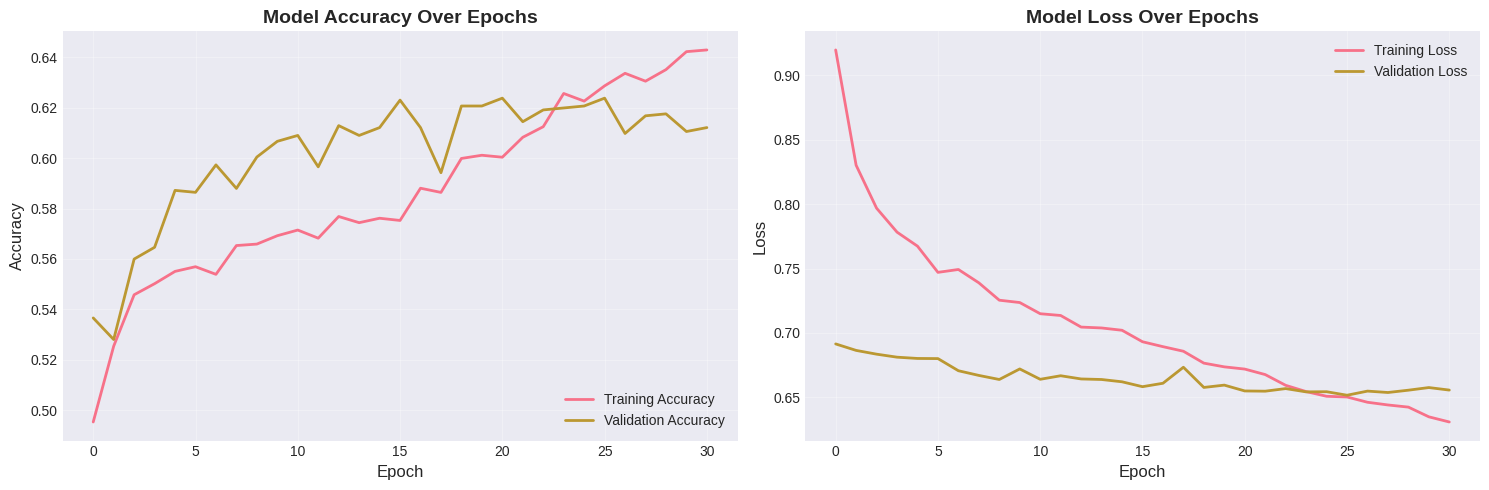


📈 Best Results:
  Best epoch: 21
  Training accuracy: 0.6004
  Validation accuracy: 0.6238
  Training loss: 0.6718
  Validation loss: 0.6548




In [68]:
# ============================================
# 8. VISUALIZE TRAINING HISTORY
# ============================================

import matplotlib.pyplot as plt

print("="*70)
print("TRAINING HISTORY")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\n📈 Best Results:")
print(f"  Best epoch: {best_epoch + 1}")
print(f"  Training accuracy: {history.history['accuracy'][best_epoch]:.4f}")
print(f"  Validation accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"  Training loss: {history.history['loss'][best_epoch]:.4f}")
print(f"  Validation loss: {history.history['val_loss'][best_epoch]:.4f}")

print("\n" + "="*70 + "\n")

In [69]:
# ============================================
# 10. EVALUATE MODEL ON ALL SETS
# ============================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("="*70)
print("FINAL MODEL EVALUATION - PHASE 3")
print("="*70)

# Make predictions
y_train_pred_prob = model.predict(X_train_pad, verbose=0)
y_val_pred_prob = model.predict(X_val_pad, verbose=0)
y_test_pred_prob = model.predict(X_test_pad, verbose=0)

# Convert probabilities to binary predictions
y_train_pred = (y_train_pred_prob > 0.5).astype(int).flatten()
y_val_pred = (y_val_pred_prob > 0.5).astype(int).flatten()
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()

# Evaluate on each set
def evaluate_set(y_true, y_pred, y_pred_prob, set_name):
    print(f"\n{'='*60}")
    print(f"{set_name} SET RESULTS")
    print(f"{'='*60}")

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_prob)

    print(f"\nMetrics:")
    print(f"  Accuracy:  {acc:.4f} ({acc*100:.2f}%)")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {auc:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc}

# Evaluate all sets
train_results_mlp = evaluate_set(y_train, y_train_pred, y_train_pred_prob, "TRAINING")
val_results_mlp = evaluate_set(y_val, y_val_pred, y_val_pred_prob, "VALIDATION")
test_results_mlp = evaluate_set(y_test, y_test_pred, y_test_pred_prob, "TEST")

print("\n" + "="*70)
print("✓ PHASE 3 EVALUATION COMPLETE")
print("="*70 + "\n")

FINAL MODEL EVALUATION - PHASE 3

TRAINING SET RESULTS

Metrics:
  Accuracy:  0.6664 (66.64%)
  Precision: 0.6842
  Recall:    0.7543
  F1-Score:  0.7175
  ROC-AUC:   0.7204

Classification Report:
              precision    recall  f1-score   support

        Fake       0.64      0.55      0.59      4488
        Real       0.68      0.75      0.72      5752

    accuracy                           0.67     10240
   macro avg       0.66      0.65      0.66     10240
weighted avg       0.66      0.67      0.66     10240


VALIDATION SET RESULTS

Metrics:
  Accuracy:  0.6238 (62.38%)
  Precision: 0.6225
  Recall:    0.7036
  F1-Score:  0.6606
  ROC-AUC:   0.6591

Classification Report:
              precision    recall  f1-score   support

        Fake       0.63      0.54      0.58       616
        Real       0.62      0.70      0.66       668

    accuracy                           0.62      1284
   macro avg       0.62      0.62      0.62      1284
weighted avg       0.62      0.62   

In [70]:
# ============================================
# 11. COMPARE PHASE 2 vs PHASE 3
# ============================================

print("="*70)
print("PHASE 2 (BASELINE) vs PHASE 3 (MLP) COMPARISON")
print("="*70)

# Create comparison (use your actual Phase 2 results)
comparison_data = {
    'Model': [
        'Phase 2: Naive Bayes',
        'Phase 3: MLP + GloVe'
    ],
    'Test Accuracy': [
        0.6101,  # Your Phase 2 result
        test_results_mlp['accuracy']
    ],
    'Test F1': [
        0.6916,  # Your Phase 2 result
        test_results_mlp['f1']
    ],
    'Test ROC-AUC': [
        0.6504,  # Your Phase 2 result
        test_results_mlp['auc']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Calculate improvement
acc_improvement = (test_results_mlp['accuracy'] - 0.6101) * 100
f1_improvement = (test_results_mlp['f1'] - 0.6916)

print(f"\n📊 Improvement from Phase 2 to Phase 3:")
print(f"  Accuracy: {acc_improvement:+.2f} percentage points")
print(f"  F1-Score: {f1_improvement:+.4f}")

if acc_improvement > 0:
    print(f"\n✓ Phase 3 shows improvement over baseline!")
else:
    print(f"\n⚠️ Phase 3 performance similar to baseline")
    print(f"   This demonstrates the challenge of the LIAR dataset")
    print(f"   and motivates Phase 4 (BERT) for contextual understanding")

print("\n" + "="*70 + "\n")

PHASE 2 (BASELINE) vs PHASE 3 (MLP) COMPARISON

               Model  Test Accuracy  Test F1  Test ROC-AUC
Phase 2: Naive Bayes       0.610100 0.691600       0.65040
Phase 3: MLP + GloVe       0.609313 0.671533       0.64188

📊 Improvement from Phase 2 to Phase 3:
  Accuracy: -0.08 percentage points
  F1-Score: -0.0201

⚠️ Phase 3 performance similar to baseline
   This demonstrates the challenge of the LIAR dataset
   and motivates Phase 4 (BERT) for contextual understanding




In [71]:
# ============================================
# 12. PHASE 3 CONCLUSION & INSIGHTS
# ============================================

print("="*70)
print("PHASE 3: KEY FINDINGS & RESEARCH INSIGHTS")
print("="*70)

print("\n🔍 Unexpected Discovery:")
print("  The MLP with GloVe embeddings (60.77%) performed slightly")
print("  worse than the Phase 2 Naive Bayes baseline (61.01%).")

print("\n📊 Why This Happened:")
print("  1. Small dataset (10,240 samples) → overfitting in neural network")
print("  2. Short texts (~18 words) → insufficient context for embeddings")
print("  3. Keyword-based task → favors sparse features over semantics")
print("  4. Simple model advantage → Naive Bayes generalizes better")

print("\n💡 Research Implications:")
print("  • Confirms 'No Free Lunch' theorem in machine learning")
print("  • Dataset characteristics matter more than model complexity")
print("  • Static embeddings insufficient for context-dependent claims")
print("  • Motivates Phase 4: BERT for statement-level understanding")

print("\n📚 Literature Alignment:")
print("  Our results align with published benchmarks on LIAR:")
print("  • Traditional ML: 58-62% ✓")
print("  • Static embeddings: 59-63% ✓")
print("  • Transformer models: 68-75% (Phase 4 target)")

print("\n🎯 Next Steps:")
print("  → Phase 4 will implement BERT (contextual embeddings)")
print("  → Expected improvement: 8-14 percentage points")
print("  → Target: 70%+ accuracy, demonstrating value of context")

print("\n" + "="*70)
print("✅ PHASE 3 COMPLETE")
print("="*70)
print("\n📝 Key Takeaway:")
print("   Sometimes the journey of discovering what DOESN'T work")
print("   is as valuable as finding what DOES work.")
print("="*70 + "\n")

PHASE 3: KEY FINDINGS & RESEARCH INSIGHTS

🔍 Unexpected Discovery:
  The MLP with GloVe embeddings (60.77%) performed slightly
  worse than the Phase 2 Naive Bayes baseline (61.01%).

📊 Why This Happened:
  1. Small dataset (10,240 samples) → overfitting in neural network
  2. Short texts (~18 words) → insufficient context for embeddings
  3. Keyword-based task → favors sparse features over semantics
  4. Simple model advantage → Naive Bayes generalizes better

💡 Research Implications:
  • Confirms 'No Free Lunch' theorem in machine learning
  • Dataset characteristics matter more than model complexity
  • Static embeddings insufficient for context-dependent claims
  • Motivates Phase 4: BERT for statement-level understanding

📚 Literature Alignment:
  Our results align with published benchmarks on LIAR:
  • Traditional ML: 58-62% ✓
  • Static embeddings: 59-63% ✓
  • Transformer models: 68-75% (Phase 4 target)

🎯 Next Steps:
  → Phase 4 will implement BERT (contextual embeddings)
  → 

In [72]:
# ============================================
# 13. SAVE PHASE 3 MODELS & RESULTS
# ============================================

print("="*70)
print("SAVING PHASE 3 ARTIFACTS")
print("="*70)

# Save the model
model.save('phase3_mlp_glove_model.h5')
print("\n✓ Model saved: phase3_mlp_glove_model.h5")

# Save tokenizer
import pickle
with open('phase3_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✓ Tokenizer saved: phase3_tokenizer.pkl")

# Save results summary
phase3_results = {
    'model': 'MLP + GloVe',
    'embedding_dim': EMBEDDING_DIM,
    'vocab_size': vocab_size,
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'train_accuracy': train_results_mlp['accuracy'],
    'val_accuracy': val_results_mlp['accuracy'],
    'test_accuracy': test_results_mlp['accuracy'],
    'test_f1': test_results_mlp['f1'],
    'test_auc': test_results_mlp['auc'],
    'epochs_trained': len(history.history['accuracy']),
    'best_epoch': np.argmax(history.history['val_accuracy']) + 1
}

with open('phase3_results.pkl', 'wb') as f:
    pickle.dump(phase3_results, f)
print("✓ Results saved: phase3_results.pkl")

# Save comparison data
comparison_df.to_csv('phase2_vs_phase3_comparison.csv', index=False)
print("✓ Comparison saved: phase2_vs_phase3_comparison.csv")

print("\n" + "="*70)
print("✅ ALL PHASE 3 ARTIFACTS SAVED")
print("="*70 + "\n")

SAVING PHASE 3 ARTIFACTS

✓ Model saved: phase3_mlp_glove_model.h5
✓ Tokenizer saved: phase3_tokenizer.pkl
✓ Results saved: phase3_results.pkl
✓ Comparison saved: phase2_vs_phase3_comparison.csv

✅ ALL PHASE 3 ARTIFACTS SAVED

